## FEATURES

* Dataset mas chico
* Features recortadas
* Sin tratamiento de outliers

In [ ]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/final_dataset_2025-09-08.xlsx'

In [ ]:
import pandas as pd

data = pd.read_excel(folder)

In [ ]:
data.head()

,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Dormitorio,barrio,municipio,precio_por_m2_construido,precio_por_m2_terreno,precio_por_m2
0,https://www.casasymas.com.uy/propiedad/183266-...,850000,3,429.0,256.0,429.0,4,4,carrasco,E,3320.312500,1981.351981,1981.351981
1,https://www.casasymas.com.uy/propiedad/940-cas...,380000,3,130.0,130.0,150.0,1,3,carrasco,E,2923.076923,2533.333333,2923.076923
2,https://www.casasymas.com.uy/propiedad/159162-...,119000,1,380.0,62.0,380.0,0,2,tres-cruces,B,1919.354839,313.157895,313.157895
3,https://www.casasymas.com.uy/propiedad/133140-...,1780000,4,263.0,263.0,1316.0,3,3,san-nicolas,E,6768.060837,1352.583587,6768.060837
4,https://www.casasymas.com.uy/propiedad/205399-...,370000,3,497.0,195.0,497.0,1,3,buceo,CH,1897.435897,744.466801,744.466801


## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [ ]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # División simple: train vs test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Preprocesador combinado
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO en training
    preprocess.fit(X_train)

    # Transformar datos
    X_train_prep = preprocess.transform(X_train)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_test_prep,
        y_train, y_test,
        preprocess,
        X_test.index
    )


In [ ]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [ ]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):
    # Parámetros por defecto optimizados para MAE
    if params is None:
        params = {
            "objective": "l1",          # minimiza MAE
            "metric": "mae",           # evalúa usando MAE
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model


In [ ]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.01,
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist"
    )

    model.fit(X_train, y_train)
    return model


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

def train_xgboost_gridsearch(X_train, y_train, cv_folds=5, n_jobs=-1):

    # Param grid muy fuerte para MAE / MAPE
    param_grid = {
        "n_estimators": [600, 900, 1200],
        "learning_rate": [0.01, 0.03, 0.05],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [1.0, 2.0, 5.0],
        "reg_alpha": [0, 0.01, 0.1]
    }

    xgb = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",  # optimizar MAE
        cv=cv_folds,
        verbose=1,
        n_jobs=n_jobs
    )

    grid.fit(X_train, y_train)

    print("\n======== MEJORES PARÁMETROS XGBOOST ========")
    print(grid.best_params_)
    print("\nMejor MAE (en log-space):", -grid.best_score_)
    print("=============================================\n")

    # Modelo final con los mejores hiperparámetros
    best_model = grid.best_estimator_

    return best_model


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,          # más árboles mejora MAE
        max_depth=20,              # evita overfitting, mantiene estabilidad
        min_samples_split=5,       # suaviza los árboles
        min_samples_leaf=2,        # controla extremos, mejora MAE
        max_features="sqrt",       # buen balance bias-variance
        bootstrap=True,            # robusto
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [ ]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


In [ ]:
def evaluation_table(model, X_test_prep, y_test, df_original, extra_cols=None):

    # Predicción en log
    y_pred_log = model.predict(X_test_prep)

    # Convertir a precio real
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # Tabla base
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
    })

    results["Error Absoluto"] = np.abs(results["Precio Real"] - results["Precio Predicho"])
    results["Error %"] = 100 * results["Error Absoluto"] / results["Precio Real"]

    # Agregar columnas originales
    if extra_cols:
        df_extra = df_original.reset_index(drop=True)[extra_cols]
        results = pd.concat([results, df_extra], axis=1)

    return results.sort_values(by="Error %", ascending=False).reset_index(drop=True)


## Target y Features

In [ ]:
features_simple = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage"]



target = "precio"

## Train Test Splits

In [ ]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=data,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


In [ ]:
data_ch = data[data["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        random_state=42
    )


In [ ]:
data_e = data[data["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_test_prep_e,
    y_train_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


## CHEQUEO INDICES

In [ ]:
print("===== CHEQUEO DE CONSISTENCIA =====")

# 1. Chequeo de tamaño del df
print(f"Filas en df filtrado: {len(data)}")

# 2. Test indices generados
print(f"Test indices (cantidad): {len(test_indices_all_municipios)}")

# 3. Chequeo de valores extremos de test_indices
print(f"Primeros test indices: {list(test_indices_all_municipios[:10])}")
print(f"Últimos test indices: {list(test_indices_all_municipios[-10:])}")

# 4. Rango válido para indices
min_idx = min(test_indices_all_municipios)
max_idx = max(test_indices_all_municipios)
print(f"Rango de test_indices: {min_idx} → {max_idx}")

if max_idx >= len(data):
    print("\n❌ ERROR: test_indices_all_municipios contiene índices que NO existen en df.")
    print("   Esto ocurre si df no fue reseteado correctamente después del groupby().apply().")
else:
    print("\n✅ OK: Todos los índices del test existen en df.")

# 5. Chequeo de tamaños test coincidencia
print(f"\nTamaño X_test_prep_all_municipios: {X_test_prep_all_municipios.shape[0]}")
print(f"Tamaño y_test_all_municipios:      {len(y_test_all_municipios)}")
print(f"Tamaño test_indices:               {len(test_indices_all_municipios)}")

if (
    X_test_prep_all_municipios.shape[0] == len(y_test_all_municipios) == len(test_indices_all_municipios)
):
    print("\n✅ OK: Los tamaños de test coinciden.")
else:
    print("\n❌ ERROR: Los tamaños de test NO coinciden. Revisar split_data_with_preprocessing.")

print("\n===== FIN DEL CHEQUEO =====\n")


===== CHEQUEO DE CONSISTENCIA =====
Filas en df filtrado: 944
Test indices (cantidad): 189
Primeros test indices: [96, 265, 811, 23, 30, 280, 569, 259, 331, 323]
Últimos test indices: [33, 31, 704, 449, 359, 764, 551, 109, 77, 215]
Rango de test_indices: 23 → 939

✅ OK: Todos los índices del test existen en df.

Tamaño X_test_prep_all_municipios: 189
Tamaño y_test_all_municipios:      189
Tamaño test_indices:               189

✅ OK: Los tamaños de test coinciden.

===== FIN DEL CHEQUEO =====



## Modelos

Entrenaremos modelos con features simples y features completas en todos los casos.

* Linear regression all_municipios
* RF municipio_ch
* RF municipio_e
* RF all_municipios
* RF Gridsearch municipio_ch
* RF Gridsearch municipio_e
* RF Gridsearch all_municipios

Nombres de modelos simples y completos:

* `model_lr_simple`, `model_lr`
* `rf_municipio_ch_simple`, `rf_municipio_ch`
* `rf_municipio_e_simple`, `rf_municipio_e`
* `rf_all_municipios_simple`, `rf_all_municipios`
* `rf_gridsearch_municipio_ch_simple`, `rf_gridsearch_municipio_ch`
* `rf_gridsearch_municipio_e_simple`, `rf_gridsearch_municipio_e`
* `rf_gridsearch_all_municipios_simple`, `rf_gridsearch_all_municipios`

## `xgb_simple`

In [ ]:
xgb_simple = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)


In [ ]:
mse_xgb_simple, r2_xgb_simple, mae_xgb_simple, medae_xgb_simple, mape_xgb_simple, mdape_xgb_simple = evaluate_model(
    xgb_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb_simple}")
print(f"R² Score: {r2_xgb_simple}")
print(f"Mean Absolute Error (MAE): {mae_xgb_simple}")
print(f"Median Absolute Error (XGB): {medae_xgb_simple}")
print(f"MAPE (XGB): {mape_xgb_simple}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_simple}")


Mean Squared Error (MSE): 39606594318.938194
R² Score: 0.6771590983371023
Mean Absolute Error (MAE): 103460.64572482639
Median Absolute Error (XGB): 51681.125000000146
MAPE (XGB): 28.07928413835304
Median Absolute Percentage Error (XGB): 18.052539893617052


## `xgb_ch`

In [ ]:
xgb_ch = train_xgboost(
    X_train_prep_ch,
    y_train_ch
)

print("XGBoost simple entrenado:", xgb_ch)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [ ]:
mse_xgb_ch, r2_xgb_ch, mae_xgb_ch, medae_xgb_ch, mape_xgb_ch, mdape_xgb_ch = evaluate_model(
    xgb_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (MSE): {mse_xgb_ch}")
print(f"R² Score: {r2_xgb_ch}")
print(f"Mean Absolute Error (MAE): {mae_xgb_ch}")
print(f"Median Absolute Error (XGB): {medae_xgb_ch}")
print(f"MAPE (XGB): {mape_xgb_ch}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_ch}")


Mean Squared Error (MSE): 10185338714.704876
R² Score: 0.6924868842634342
Mean Absolute Error (MAE): 68011.92460937506
Median Absolute Error (XGB): 36202.265625000175
MAPE (XGB): 17.691199571914886
Median Absolute Percentage Error (XGB): 10.907122851668833


## `xgb_e`

In [ ]:
xgb_e = train_xgboost(
    X_train_prep_e,
    y_train_e
)

print("XGBoost simple entrenado:", xgb_e)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [ ]:
mse_xgb_e, r2_xgb_e, mae_xgb_e, medae_xgb_e, mape_xgb_e, mdape_xgb_e = evaluate_model(
    xgb_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (MSE): {mse_xgb_e}")
print(f"R² Score: {r2_xgb_e}")
print(f"Mean Absolute Error (MAE): {mae_xgb_e}")
print(f"Median Absolute Error (XGB): {medae_xgb_e}")
print(f"MAPE (XGB): {mape_xgb_e}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_e}")


Mean Squared Error (MSE): 40935768407.404434
R² Score: 0.6705908067274935
Mean Absolute Error (MAE): 118603.34609375003
Median Absolute Error (XGB): 82000.15624999974
MAPE (XGB): 27.90969499618842
Median Absolute Percentage Error (XGB): 15.16689202599863


## `model_lgbm_simple` (all municipios)

In [ ]:
model_lgbm_simple = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm_simple)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 755, number of used features: 24
[LightGBM] [Info] Start training from score 12.594730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
mse_lgbm_simple, r2_lgbm_simple, mae_lgbm_simple, medae_lgbm_simple, mape_lgbm_simple, mdape_lgbm_simple = evaluate_model(
    model_lgbm_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm_simple}")
print(f"R² Score (LGBM): {r2_lgbm_simple}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm_simple}")
print(f"Median Absolute Error (LGBM): {medae_lgbm_simple}")
print(f"MAPE (LGBM): {mape_lgbm_simple}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm_simple}")

Mean Squared Error (LGBM): 42685415251.43254
R² Score (LGBM): 0.6520630419102107
Mean Absolute Error (LGBM): 110364.01751515875
Median Absolute Error (LGBM): 54514.49434137551
MAPE (LGBM): 31.120146674798665
Median Absolute Percentage Error (LGBM): 19.29652184005349


## `lgbm_ch_simple`

In [ ]:
# Modelo CH simple
lgbm_ch_simple = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH simple entrenado:", lgbm_ch_simple)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 11
[LightGBM] [Info] Start training from score 12.668201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
mse_lgbm_ch_simple, r2_lgbm_ch_simple, mae_lgbm_ch_simple, medae_lgbm_ch_simple, mape_lgbm_ch_simple, mdape_lgbm_ch_simple = evaluate_model(
    lgbm_ch_simple,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH simple): {mse_lgbm_ch_simple}")
print(f"R² Score (LGBM CH simple): {r2_lgbm_ch_simple}")
print(f"Mean Absolute Error (LGBM CH simple): {mae_lgbm_ch_simple}")
print(f"Median Absolute Error (LGBM CH simple): {medae_lgbm_ch_simple}")
print(f"MAPE (LGBM CH simple): {mape_lgbm_ch_simple}")
print(f"Median Absolute Percentage Error (LGBM CH simple): {mdape_lgbm_ch_simple}")

Mean Squared Error (LGBM CH simple): 10181654441.700033
R² Score (LGBM CH simple): 0.6925981188823976
Mean Absolute Error (LGBM CH simple): 70156.13493925534
Median Absolute Error (LGBM CH simple): 39516.2998014576
MAPE (LGBM CH simple): 18.33858883786673
Median Absolute Percentage Error (LGBM CH simple): 13.894009151822093


## `lgbm_e_simple`

In [ ]:
# Modelo E simple
lgbm_e_simple = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E simple entrenado:", lgbm_e_simple)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 277, number of used features: 10
[LightGBM] [Info] Start training from score 13.180633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
mse_lgbm_e_simple, r2_lgbm_e_simple, mae_lgbm_e_simple, medae_lgbm_e_simple, mape_lgbm_e_simple, mdape_lgbm_e_simple = evaluate_model(
    lgbm_e_simple,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E simple): {mse_lgbm_e_simple}")
print(f"R² Score (LGBM E simple): {r2_lgbm_e_simple}")
print(f"Mean Absolute Error (LGBM E simple): {mae_lgbm_e_simple}")
print(f"Median Absolute Error (LGBM E simple): {medae_lgbm_e_simple}")
print(f"MAPE (LGBM E simple): {mape_lgbm_e_simple}")
print(f"Median Absolute Percentage Error (LGBM E simple): {mdape_lgbm_e_simple}")


Mean Squared Error (LGBM E simple): 60230443903.079796
R² Score (LGBM E simple): 0.5153269937649505
Mean Absolute Error (LGBM E simple): 137204.0163589448
Median Absolute Error (LGBM E simple): 77432.00284318475
MAPE (LGBM E simple): 37.57195128328897
Median Absolute Percentage Error (LGBM E simple): 14.874388603102334


## `model_lr_simple`

Todos los municipios, features simples

In [ ]:
model_lr_simple = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr_simple)

Modelo entrenado: LinearRegression()


In [ ]:
mse_lr_simple, r2_lr_simple, mae_lr_simple, medae_lr_simple, mape_lr_simple, mdape_lr_simple  = evaluate_model(model_lr_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr_simple}")
print(f"R² Score (Real): {r2_lr_simple}")
print(f"Mean Absolute Error (Real): {mae_lr_simple}")
print(f"Median Absolute Error (Real): {medae_lr_simple}")
print(f"MAPE: {mape_lr_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple}")

Mean Squared Error (Real): 38168301374.2124
R² Score (Real): 0.6888828983536222
Mean Absolute Error (Real): 104144.91371769579
Median Absolute Error (Real): 53980.27940605554
MAPE: 28.38989472658382
Median Absolute Percentage Error (%): 20.877030793026233


## `model_lr_ch`

In [ ]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [ ]:
mse_lr_simple_ch, r2_lr_simple_ch, mae_lr_simple_ch, medae_lr_simple_ch, mape_lr_simple_ch, mdape_lr_simple_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_simple_ch}")
print(f"R² Score (Real): {r2_lr_simple_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_ch}")
print(f"Median Absolute Error (Real): {medae_lr_simple_ch}")
print(f"MAPE: {mape_lr_simple_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_ch}")

Mean Squared Error (Real): 13207051060.71439
R² Score (Real): 0.6012561255809079
Mean Absolute Error (Real): 75474.46966535973
Median Absolute Error (Real): 49948.755215854515
MAPE: 19.084423839342477
Median Absolute Percentage Error (%): 17.58253578999503


## `model_lr_e`

In [ ]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [ ]:
mse_lr_simple_e, r2_lr_simple_e, mae_lr_simple_e, medae_lr_simple_e, mape_lr_simple_e, mdape_lr_simple_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_simple_e}")
print(f"R² Score (Real): {r2_lr_simple_e}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_e}")
print(f"Median Absolute Error (Real): {medae_lr_simple_e}")
print(f"MAPE: {mape_lr_simple_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_e}")

Mean Squared Error (Real): 33122549458.415813
R² Score (Real): 0.7334636011314766
Mean Absolute Error (Real): 104798.33022962937
Median Absolute Error (Real): 53422.69109860115
MAPE: 25.6071039930077
Median Absolute Percentage Error (%): 15.468049332170386


## `rf_all_municipios_simple`

In [ ]:
rf_all_municipios_simple = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [ ]:
mse_rf_all_municipios_simple, r2_rf_all_municipios_simple, mae_rf_all_municipios_simple, medae_rf_all_municipios_simple, mape_rf_all_municipios_simple, mdape_rf_all_municipios_simple = evaluate_model(rf_all_municipios_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios_simple}")
print(f"R² Score (Real): {r2_rf_all_municipios_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios_simple}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios_simple}")
print(f"MAPE: {mape_rf_all_municipios_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios_simple}")

Mean Squared Error (Real): 40770595133.25307
R² Score (Real): 0.6676711057719331
Mean Absolute Error (Real): 102674.85541701585
Median Absolute Error (Real): 51314.25535307794
MAPE: 28.65939699405022
Median Absolute Percentage Error (%): 18.924665797663405


## `rf_municipio_ch_simple`

In [ ]:
rf_municipio_ch_simple = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [ ]:
mse_rf_municipio_ch_simple, r2_rf_municipio_ch_simple, mae_rf_municipio_ch_simple, medae_rf_municipio_ch_simple, mape_rf_municipio_ch_simple, mdape_rf_municipio_ch_simple = evaluate_model(rf_municipio_ch_simple, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch_simple}")
print(f"R² Score (Real): {r2_rf_municipio_ch_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch_simple}")
print(f"MAPE: {mape_rf_municipio_ch_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch_simple}")

Mean Squared Error (Real): 8775760423.23935
R² Score (Real): 0.7350445079639976
Mean Absolute Error (Real): 66218.89117837448
Median Absolute Error (Real): 38043.45686816859
MAPE: 17.324925854597033
Median Absolute Percentage Error (%): 14.96975143896306


## `rf_municipio_e_simple`

municipio e y features simples

In [ ]:
rf_municipio_e_simple = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [ ]:
mse_rf_municipio_e_simple, r2_rf_municipio_e_simple, mae_rf_municipio_e_simple, medae_rf_municipio_e_simple, mape_rf_municipio_e_simple, mdape_rf_municipio_e_simple = evaluate_model(rf_municipio_e_simple, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e_simple}")
print(f"R² Score (Real): {r2_rf_municipio_e_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e_simple}")
print(f"MAPE: {mape_rf_municipio_e_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e_simple}")

Mean Squared Error (Real): 36970030953.45701
R² Score (Real): 0.702503005429475
Mean Absolute Error (Real): 106161.88664556318
Median Absolute Error (Real): 74234.22307445641
MAPE: 26.525554906560682
Median Absolute Percentage Error (%): 13.016099266956472


## `xgb_gs_all_municipios`

In [ ]:
xgb_gs_all_municipios = train_xgboost_gridsearch(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", xgb_gs_all_municipios)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


In [ ]:
mse_xgb_gs_all_municipios, r2_xgb_gs_all_municipios, mae_xgb_gs_all_municipios, medae_xgb_gs_all_municipios, mape_xgb_gs_all_municipios, mdape_xgb_gs_all_municipios = evaluate_model(xgb_gs_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_xgb_gs_all_municipios}")
print(f"R² Score (Real): {r2_xgb_gs_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_all_municipios}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_all_municipios}")
print(f"MAPE: {mape_xgb_gs_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_all_municipios}")

## `xgb_gs_ch`

In [ ]:
xgb_gs_ch = train_xgboost_gridsearch(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", xgb_gs_ch)

In [ ]:
mse_xgb_gs_ch, r2_xgb_gs_ch, mae_xgb_gs_ch, medae_xgb_gs_ch, mape_xgb_gs_ch, mdape_xgb_gs_ch = evaluate_model(xgb_gs_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_xgb_gs_ch}")
print(f"R² Score (Real): {r2_xgb_gs_ch}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_ch}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_ch}")
print(f"MAPE: {mape_xgb_gs_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_ch}")

## `xgb_gs_e`

In [ ]:
xgb_gs_e = train_xgboost_gridsearch(X_train_prep_e, y_train_e)

print("Modelo entrenado:", xgb_gs_e)

In [ ]:
mse_xgb_gs_e, r2_xgb_gs_e, mae_xgb_gs_e, medae_xgb_gs_e, mape_xgb_gs_e, mdape_xgb_gs_e = evaluate_model(xgb_gs_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_xgb_gs_e}")
print(f"R² Score (Real): {r2_xgb_gs_e}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_e}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_e}")
print(f"MAPE: {mape_xgb_gs_e}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_e}")

## Evaluate Performance

In [ ]:
# Lista de modelos simples
all_models_simple_custom = [
    model_lr_simple,
    model_lr_ch,
    model_lr_e,
    xgb_simple,
    xgb_ch,
    xgb_e,
    model_lgbm_simple,
    lgbm_ch_simple,
    lgbm_e_simple,
    rf_all_municipios_simple,
    rf_municipio_ch_simple,
    rf_municipio_e_simple
]

# Métricas correspondientes (en el mismo orden)
mse_models_simple_custom = [
    mse_lr_simple,
    mse_lr_simple_ch,
    mse_lr_simple_e,
    mse_xgb_simple,
    mse_xgb_ch,
    mse_xgb_e,
    mse_lgbm_simple,
    mse_lgbm_ch_simple,
    mse_lgbm_e_simple,
    mse_rf_all_municipios_simple,
    mse_rf_municipio_ch_simple,
    mse_rf_municipio_e_simple
]

r2_models_simple_custom = [
    r2_lr_simple,
    r2_lr_simple_ch,
    r2_lr_simple_e,
    r2_xgb_simple,
    r2_xgb_ch,
    r2_xgb_e,
    r2_lgbm_simple,
    r2_lgbm_ch_simple,
    r2_lgbm_e_simple,
    r2_rf_all_municipios_simple,
    r2_rf_municipio_ch_simple,
    r2_rf_municipio_e_simple
]

mae_models_simple_custom = [
    mae_lr_simple,
    mae_lr_simple_ch,
    mae_lr_simple_e,
    mae_xgb_simple,
    mae_xgb_ch,
    mae_xgb_e,
    mae_lgbm_simple,
    mae_lgbm_ch_simple,
    mae_lgbm_e_simple,
    mae_rf_all_municipios_simple,
    mae_rf_municipio_ch_simple,
    mae_rf_municipio_e_simple
]

medae_models_simple_custom = [
    medae_lr_simple,
    medae_lr_simple_ch,
    medae_lr_simple_e,
    medae_xgb_simple,
    medae_xgb_ch,
    medae_xgb_e,
    medae_lgbm_simple,
    medae_lgbm_ch_simple,
    medae_lgbm_e_simple,
    medae_rf_all_municipios_simple,
    medae_rf_municipio_ch_simple,
    medae_rf_municipio_e_simple
]

mape_models_simple_custom = [
    mape_lr_simple,
    mape_lr_simple_ch,
    mape_lr_simple_e,
    mape_xgb_simple,
    mape_xgb_ch,
    mape_xgb_e,
    mape_lgbm_simple,
    mape_lgbm_ch_simple,
    mape_lgbm_e_simple,
    mape_rf_all_municipios_simple,
    mape_rf_municipio_ch_simple,
    mape_rf_municipio_e_simple
]

mdape_models_simple_custom = [
    mdape_lr_simple,
    mdape_lr_simple_ch,
    mdape_lr_simple_e,
    mdape_xgb_simple,
    mdape_xgb_ch,
    mdape_xgb_e,
    mdape_lgbm_simple,
    mdape_lgbm_ch_simple,
    mdape_lgbm_e_simple,
    mdape_rf_all_municipios_simple,
    mdape_rf_municipio_ch_simple,
    mdape_rf_municipio_e_simple
]

In [ ]:
# Nombres de los modelos
model_names_simple_custom = [
    "LR simple",
    "LR CH",
    "LR E",
    "XGB simple",
    "XGB CH",
    "XGB E",
    "LGBM simple",
    "LGBM CH simple",
    "LGBM E simple",
    "RF simple",
    "RF CH simple",
    "RF E simple"
]

# Generar la tabla
tabla_simple_custom = crear_tabla_resultados(
    model_names_simple_custom,
    mse_models_simple_custom,
    r2_models_simple_custom,
    mae_models_simple_custom,
    medae_models_simple_custom,
    mape_models_simple_custom,
    mdape_models_simple_custom
)

print("Resultados modelos:")
tabla_simple_custom

Resultados modelos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,LR simple,"104,144.91","53,980.28","38,168,301,374.21",0.69,28.39,20.88
1,LR CH,"75,474.47","49,948.76","13,207,051,060.71",0.60,19.08,17.58
2,LR E,"104,798.33","53,422.69","33,122,549,458.42",0.73,25.61,15.47
3,XGB simple,"103,460.65","51,681.13","39,606,594,318.94",0.68,28.08,18.05
4,XGB CH,"68,011.92","36,202.27","10,185,338,714.70",0.69,17.69,10.91
5,XGB E,"118,603.35","82,000.16","40,935,768,407.40",0.67,27.91,15.17
6,LGBM simple,"110,364.02","54,514.49","42,685,415,251.43",0.65,31.12,19.30
7,LGBM CH simple,"70,156.13","39,516.30","10,181,654,441.70",0.69,18.34,13.89
8,LGBM E simple,"137,204.02","77,432.00","60,230,443,903.08",0.52,37.57,14.87
9,RF simple,"102,674.86","51,314.26","40,770,595,133.25",0.67,28.66,18.92


## Model Performance

### `xgb_simple`

In [ ]:
results_model_xgb_simple = evaluation_table(
    xgb_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    df.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_xgb_simple.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"230,000.00","626,904.69","396,904.69",172.57,https://www.casasymas.com.uy/propiedad/209619-...
1,"85,000.00","187,033.09","102,033.09",120.04,https://www.casasymas.com.uy/propiedad/189130-...
2,"68,000.00","141,644.19","73,644.19",108.30,https://www.casasymas.com.uy/propiedad/200662-...
3,"75,000.00","146,392.25","71,392.25",95.19,https://www.casasymas.com.uy/propiedad/204681-...
4,"170,000.00","19,553.73","150,446.27",88.50,https://www.casasymas.com.uy/propiedad/207263-...
5,"439,000.00","809,929.88","370,929.88",84.49,https://www.casasymas.com.uy/propiedad/74195-c...
6,"240,000.00","441,006.84","201,006.84",83.75,https://www.casasymas.com.uy/propiedad/46209-c...
7,"118,000.00","215,099.77","97,099.77",82.29,https://www.casasymas.com.uy/propiedad/183869-...
8,"100,000.00","181,431.59","81,431.59",81.43,https://www.casasymas.com.uy/propiedad/183323-...
9,"665,000.00","1,197,172.25","532,172.25",80.03,https://www.casasymas.com.uy/propiedad/228248-...


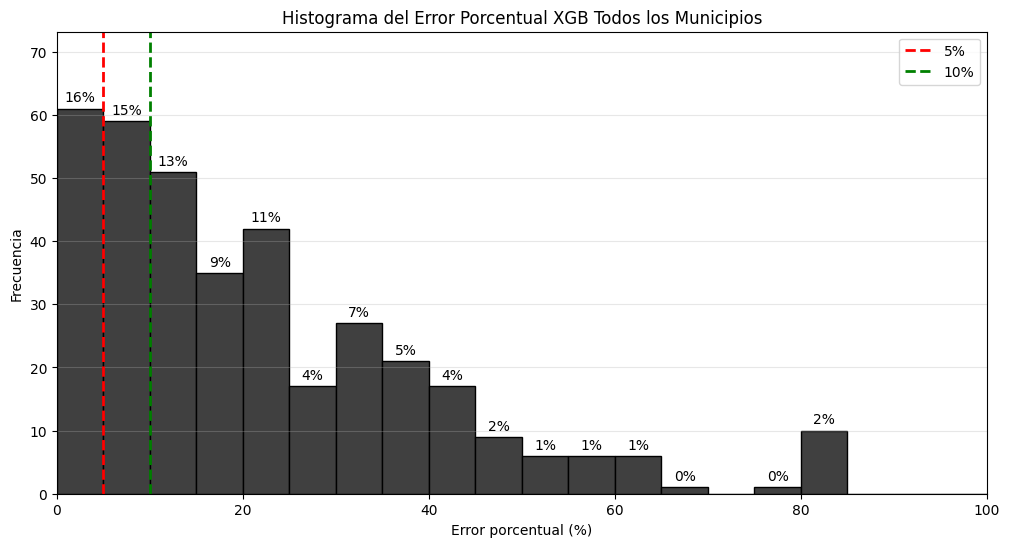

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_ch`

In [ ]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_ch):
    X_test_ch_dense = X_test_prep_ch.toarray()
else:
    X_test_ch_dense = X_test_prep_ch

X_test_ch_df = pd.DataFrame(X_test_ch_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_ch_reset = y_test_ch.reset_index(drop=True)

# Filas originales del test
test_rows_ch = data_ch.loc[test_indices_ch].reset_index(drop=True)

# Evaluación
results_model_xgb_ch = evaluation_table(
    lgbm_ch_simple,
    X_test_ch_df,
    y_test_ch_reset,
    test_rows_ch,
    extra_cols
)

results_model_xgb_ch.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"300,000.00","523,658.67","223,658.67",74.55,https://www.casasymas.com.uy/propiedad/145602-...
1,"800,000.00","242,151.15","557,848.85",69.73,https://www.casasymas.com.uy/propiedad/189037-...
2,"220,000.00","317,472.53","97,472.53",44.31,https://www.casasymas.com.uy/propiedad/138003-...
3,"530,000.00","315,004.30","214,995.70",40.57,https://www.casasymas.com.uy/propiedad/108760-...
4,"330,000.00","456,042.08","126,042.08",38.19,https://www.casasymas.com.uy/propiedad/187067-...
5,"515,000.00","343,808.19","171,191.81",33.24,https://www.casasymas.com.uy/propiedad/191507-...
6,"350,000.00","233,668.34","116,331.66",33.24,https://www.casasymas.com.uy/propiedad/216149-...
7,"140,000.00","185,436.04","45,436.04",32.45,https://www.casasymas.com.uy/propiedad/223429-...
8,"498,000.00","338,466.20","159,533.80",32.03,https://www.casasymas.com.uy/propiedad/126765-...
9,"439,000.00","577,236.60","138,236.60",31.49,https://www.casasymas.com.uy/propiedad/74195-c...


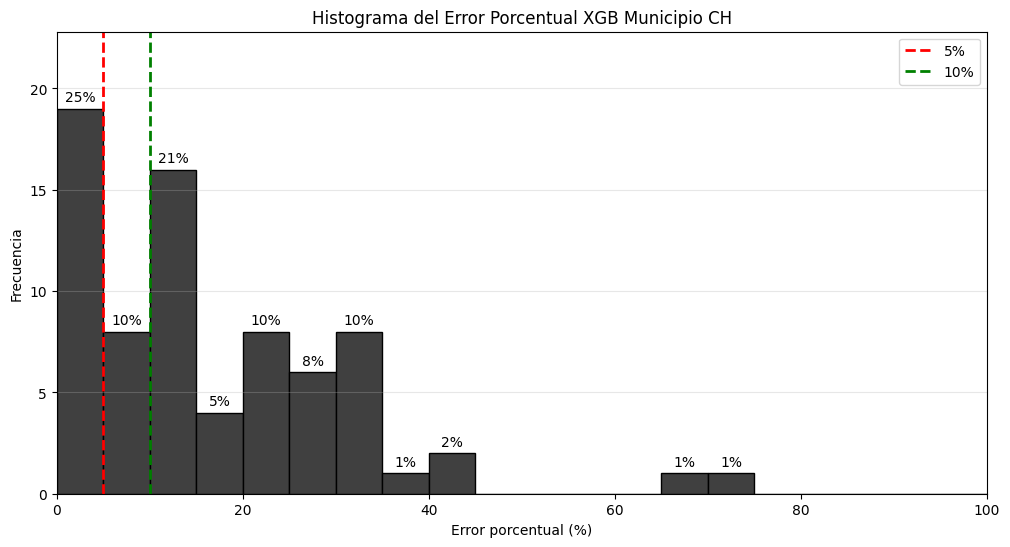

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_e`

In [ ]:
results_model_xgb_e = evaluation_table(
    xgb_e,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_xgb_e.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"75,000.00","160,797.14","85,797.14",114.40,https://www.casasymas.com.uy/propiedad/190700-...
1,"260,000.00","557,177.69","297,177.69",114.30,https://www.casasymas.com.uy/propiedad/188428-...
2,"360,000.00","664,207.62","304,207.63",84.50,https://www.casasymas.com.uy/propiedad/191076-...
3,"625,000.00","1,030,302.12","405,302.12",64.85,https://www.casasymas.com.uy/propiedad/1326-ca...
4,"148,000.00","231,575.47","83,575.47",56.47,https://www.casasymas.com.uy/propiedad/216574-...
5,"1,150,000.00","526,310.62","623,689.38",54.23,https://www.casasymas.com.uy/propiedad/201123-...
6,"1,200,000.00","573,604.25","626,395.75",52.20,https://www.casasymas.com.uy/propiedad/200076-...
7,"580,000.00","879,230.12","299,230.13",51.59,https://www.casasymas.com.uy/propiedad/198782-...
8,"309,000.00","163,835.41","145,164.59",46.98,https://www.casasymas.com.uy/propiedad/208241-...
9,"394,000.00","576,592.25","182,592.25",46.34,https://www.casasymas.com.uy/propiedad/200453-...


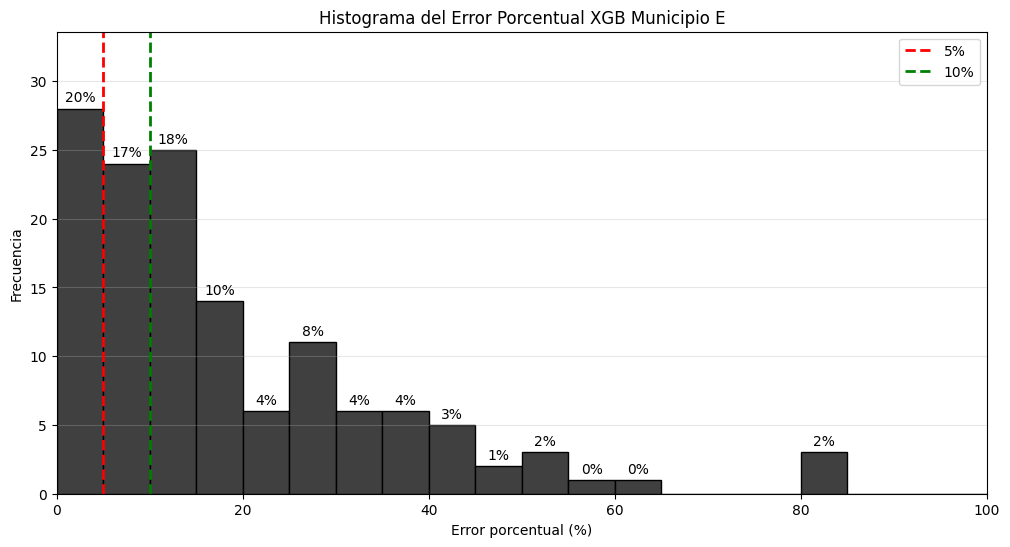

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lgbm_simple`

In [ ]:
results_model_lgbm_simple = evaluation_table(
    model_lgbm_simple,
    X_test_prep_all_municipios,   # ← NO convertir a DataFrame
    y_test_all_municipios.values, # ← log target correcto
    df.loc[test_indices_all_municipios],  # ← datos originales
    extra_cols=["url"]
)

results_model_lgbm_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"230,000.00","689,711.49","459,711.49",199.87,https://www.casasymas.com.uy/propiedad/209619-...
1,"65,000.00","168,686.63","103,686.63",159.52,https://www.casasymas.com.uy/propiedad/163448-...
2,"45,000.00","111,333.36","66,333.36",147.41,https://www.casasymas.com.uy/propiedad/210787-...
3,"79,000.00","174,000.83","95,000.83",120.25,https://www.casasymas.com.uy/propiedad/204682-...
4,"68,000.00","149,519.29","81,519.29",119.88,https://www.casasymas.com.uy/propiedad/200662-...
5,"85,000.00","182,275.09","97,275.09",114.44,https://www.casasymas.com.uy/propiedad/189130-...
6,"75,000.00","149,862.66","74,862.66",99.82,https://www.casasymas.com.uy/propiedad/204681-...
7,"130,000.00","257,658.39","127,658.39",98.20,https://www.casasymas.com.uy/propiedad/217172-...
8,"180,000.00","329,896.11","149,896.11",83.28,https://www.casasymas.com.uy/propiedad/118313-...
9,"100,000.00","181,179.72","81,179.72",81.18,https://www.casasymas.com.uy/propiedad/183323-...


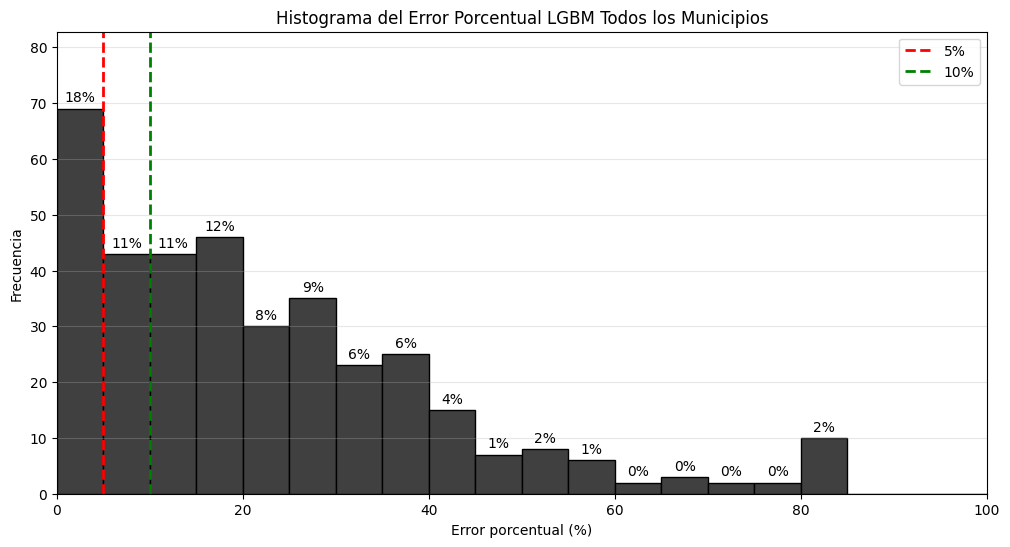

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_ch_simple`

In [ ]:
results_model_lgbm_ch_simple = evaluation_table(
    lgbm_ch_simple,
    X_test_prep_ch,   # ← NO convertir a DataFrame
    y_test_ch.values, # ← log target correcto
    df.loc[test_indices_ch],  # ← datos originales
    extra_cols=["url"]
)

results_model_lgbm_ch_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"300,000.00","523,658.67","223,658.67",74.55,https://www.casasymas.com.uy/propiedad/145602-...
1,"800,000.00","242,151.15","557,848.85",69.73,https://www.casasymas.com.uy/propiedad/189037-...
2,"220,000.00","317,472.53","97,472.53",44.31,https://www.casasymas.com.uy/propiedad/138003-...
3,"530,000.00","315,004.30","214,995.70",40.57,https://www.casasymas.com.uy/propiedad/108760-...
4,"330,000.00","456,042.08","126,042.08",38.19,https://www.casasymas.com.uy/propiedad/187067-...
5,"515,000.00","343,808.19","171,191.81",33.24,https://www.casasymas.com.uy/propiedad/191507-...
6,"350,000.00","233,668.34","116,331.66",33.24,https://www.casasymas.com.uy/propiedad/216149-...
7,"140,000.00","185,436.04","45,436.04",32.45,https://www.casasymas.com.uy/propiedad/223429-...
8,"498,000.00","338,466.20","159,533.80",32.03,https://www.casasymas.com.uy/propiedad/126765-...
9,"439,000.00","577,236.60","138,236.60",31.49,https://www.casasymas.com.uy/propiedad/74195-c...


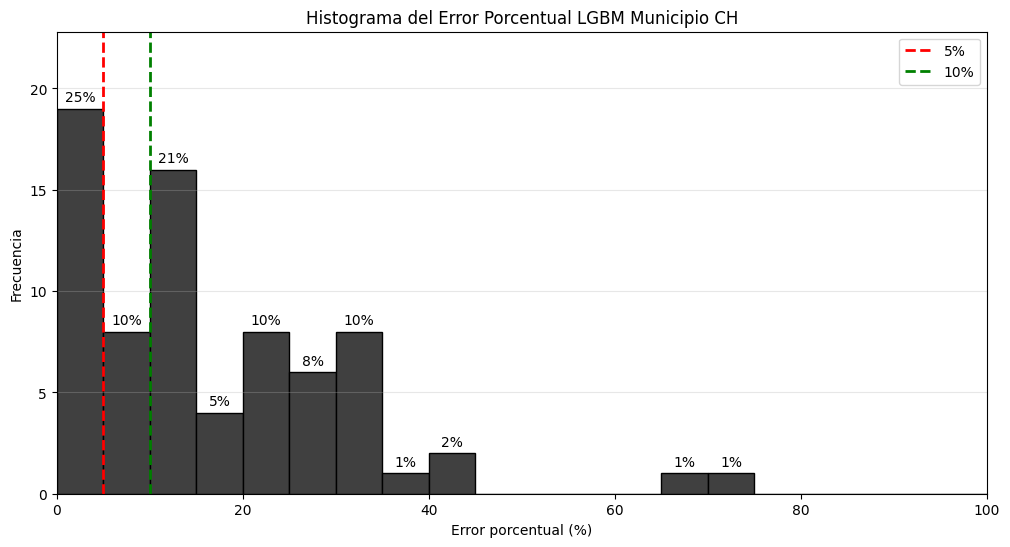

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_ch_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_e_simple`

In [ ]:
results_model_lgbm_e_simple = evaluation_table(
    lgbm_e_simple,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_lgbm_e_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"75,000.00","183,427.57","108,427.57",144.57,https://www.casasymas.com.uy/propiedad/190700-...
1,"260,000.00","503,978.56","243,978.56",93.84,https://www.casasymas.com.uy/propiedad/188428-...
2,"360,000.00","647,472.04","287,472.04",79.85,https://www.casasymas.com.uy/propiedad/191076-...
3,"148,000.00","244,657.95","96,657.95",65.31,https://www.casasymas.com.uy/propiedad/216574-...
4,"2,000,000.00","786,269.07","1,213,730.93",60.69,https://www.casasymas.com.uy/propiedad/1322-ca...
5,"375,000.00","597,411.47","222,411.47",59.31,https://www.casasymas.com.uy/propiedad/208201-...
6,"1,150,000.00","492,413.38","657,586.62",57.18,https://www.casasymas.com.uy/propiedad/201123-...
7,"1,500,000.00","700,658.69","799,341.31",53.29,https://www.casasymas.com.uy/propiedad/185047-...
8,"1,200,000.00","596,524.23","603,475.77",50.29,https://www.casasymas.com.uy/propiedad/200076-...
9,"390,000.00","584,367.06","194,367.06",49.84,https://www.casasymas.com.uy/propiedad/1296-ca...


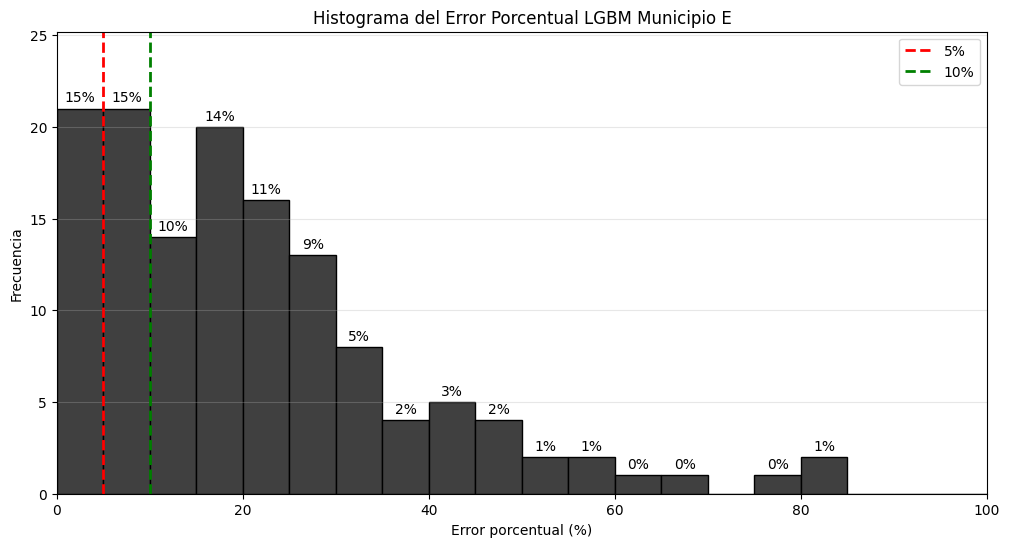

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_e_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_simple`

In [ ]:
results_model_lr_simple = evaluation_table(
    model_lr_simple,
    X_test_prep_all_municipios,   # ← NO convertir a DataFrame
    y_test_all_municipios.values, # ← log target correcto
    df.loc[test_indices_all_municipios],  # ← datos originales
    extra_cols=["url"]
)

results_model_lr_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"230,000.00","524,010.12","294,010.12",127.83,https://www.casasymas.com.uy/propiedad/209619-...
1,"85,000.00","184,611.20","99,611.20",117.19,https://www.casasymas.com.uy/propiedad/189130-...
2,"75,000.00","150,575.52","75,575.52",100.77,https://www.casasymas.com.uy/propiedad/204681-...
3,"440,000.00","878,345.95","438,345.95",99.62,https://www.casasymas.com.uy/propiedad/198708-...
4,"240,000.00","478,515.95","238,515.95",99.38,https://www.casasymas.com.uy/propiedad/46209-c...
5,"180,000.00","353,779.38","173,779.38",96.54,https://www.casasymas.com.uy/propiedad/118313-...
6,"203,400.00","382,414.88","179,014.88",88.01,https://www.casasymas.com.uy/propiedad/90237-c...
7,"125,000.00","226,539.92","101,539.92",81.23,https://www.casasymas.com.uy/propiedad/227025-...
8,"130,000.00","232,262.72","102,262.72",78.66,https://www.casasymas.com.uy/propiedad/217172-...
9,"139,000.00","245,698.88","106,698.88",76.76,https://www.casasymas.com.uy/propiedad/196206-...


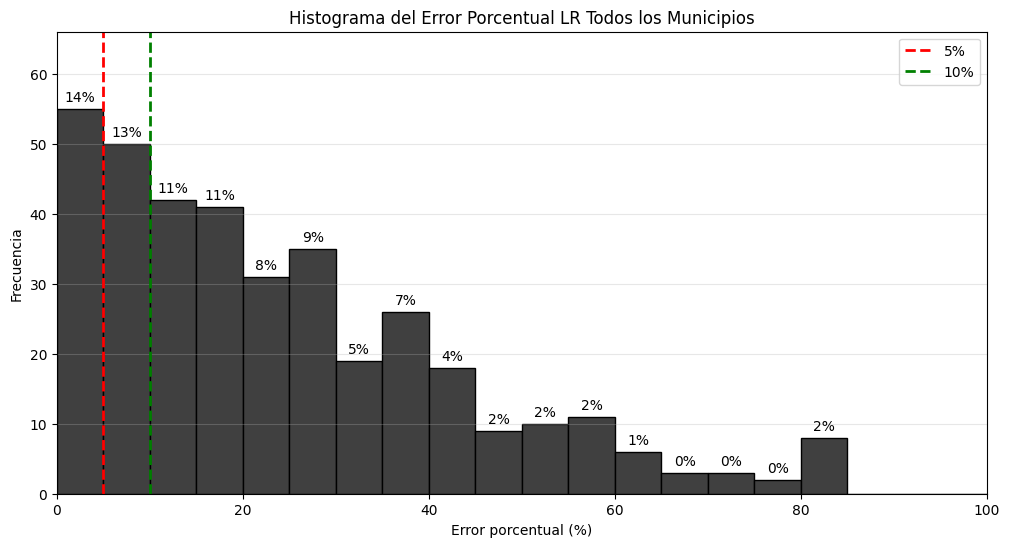

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_ch`

In [ ]:
results_model_lr_ch = evaluation_table(
    model_lr_ch,
    X_test_prep_ch,   # ← NO convertir a DataFrame
    y_test_ch.values, # ← log target correcto
    df.loc[test_indices_ch],  # ← datos originales
    extra_cols=["url"]
)

results_model_lr_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"300,000.00","499,834.04","199,834.04",66.61,https://www.casasymas.com.uy/propiedad/145602-...
1,"800,000.00","275,381.15","524,618.85",65.58,https://www.casasymas.com.uy/propiedad/189037-...
2,"450,000.00","709,173.50","259,173.50",57.59,https://www.casasymas.com.uy/propiedad/183528-...
3,"420,000.00","648,431.84","228,431.84",54.39,https://www.casasymas.com.uy/propiedad/50102-c...
4,"190,000.00","281,654.12","91,654.12",48.24,https://www.casasymas.com.uy/propiedad/208656-...
5,"130,000.00","191,744.02","61,744.02",47.50,https://www.casasymas.com.uy/propiedad/203660-...
6,"405,000.00","596,575.48","191,575.48",47.30,https://www.casasymas.com.uy/propiedad/221984-...
7,"110,000.00","159,296.08","49,296.08",44.81,https://www.casasymas.com.uy/propiedad/179372-...
8,"195,000.00","269,873.74","74,873.74",38.40,https://www.casasymas.com.uy/propiedad/233586-...
9,"720,000.00","452,974.95","267,025.05",37.09,https://www.casasymas.com.uy/propiedad/196276-...


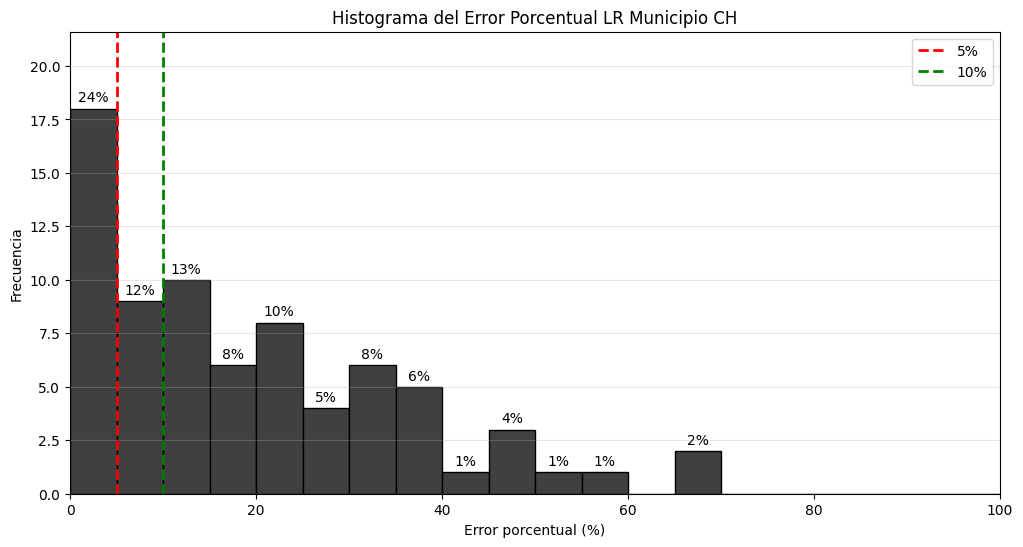

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_e`

In [ ]:
results_model_lr_e = evaluation_table(
    model_lr_e,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_lr_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"260,000.00","665,907.23","405,907.23",156.12,https://www.casasymas.com.uy/propiedad/188428-...
1,"75,000.00","177,572.99","102,572.99",136.76,https://www.casasymas.com.uy/propiedad/190700-...
2,"203,400.00","390,228.79","186,828.79",91.85,https://www.casasymas.com.uy/propiedad/90237-c...
3,"625,000.00","1,087,522.49","462,522.49",74.00,https://www.casasymas.com.uy/propiedad/1326-ca...
4,"360,000.00","624,386.00","264,386.00",73.44,https://www.casasymas.com.uy/propiedad/191076-...
5,"148,000.00","254,157.13","106,157.13",71.73,https://www.casasymas.com.uy/propiedad/216574-...
6,"2,000,000.00","743,434.76","1,256,565.24",62.83,https://www.casasymas.com.uy/propiedad/1322-ca...
7,"445,000.00","685,626.19","240,626.19",54.07,https://www.casasymas.com.uy/propiedad/131852-...
8,"1,200,000.00","567,423.04","632,576.96",52.71,https://www.casasymas.com.uy/propiedad/200076-...
9,"575,000.00","863,589.43","288,589.43",50.19,https://www.casasymas.com.uy/propiedad/203193-...


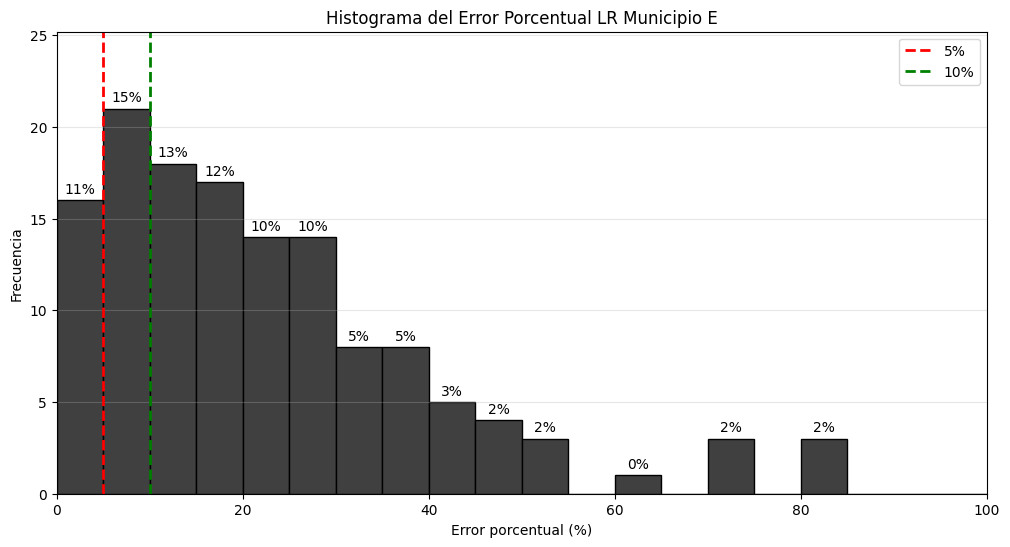

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_all_municipios_simple`

In [ ]:
results_model_rf_all_municipios_simple = evaluation_table(
    rf_all_municipios_simple,
    X_test_prep_all_municipios,   # ← NO convertir a DataFrame
    y_test_all_municipios.values, # ← log target correcto
    df.loc[test_indices_all_municipios],  # ← datos originales
    extra_cols=["url"]
)

results_model_rf_all_municipios_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"45,000.00","148,598.05","103,598.05",230.22,https://www.casasymas.com.uy/propiedad/210787-...
1,"68,000.00","169,476.18","101,476.18",149.23,https://www.casasymas.com.uy/propiedad/200662-...
2,"65,000.00","157,389.89","92,389.89",142.14,https://www.casasymas.com.uy/propiedad/163448-...
3,"230,000.00","533,702.74","303,702.74",132.04,https://www.casasymas.com.uy/propiedad/209619-...
4,"90,000.00","208,058.01","118,058.01",131.18,https://www.casasymas.com.uy/propiedad/228801-...
5,"118,000.00","266,958.89","148,958.89",126.24,https://www.casasymas.com.uy/propiedad/183869-...
6,"79,000.00","174,393.91","95,393.91",120.75,https://www.casasymas.com.uy/propiedad/204682-...
7,"85,000.00","181,024.26","96,024.26",112.97,https://www.casasymas.com.uy/propiedad/189130-...
8,"100,000.00","210,553.04","110,553.04",110.55,https://www.casasymas.com.uy/propiedad/183323-...
9,"165,000.00","339,412.35","174,412.35",105.70,https://www.casasymas.com.uy/propiedad/187249-...


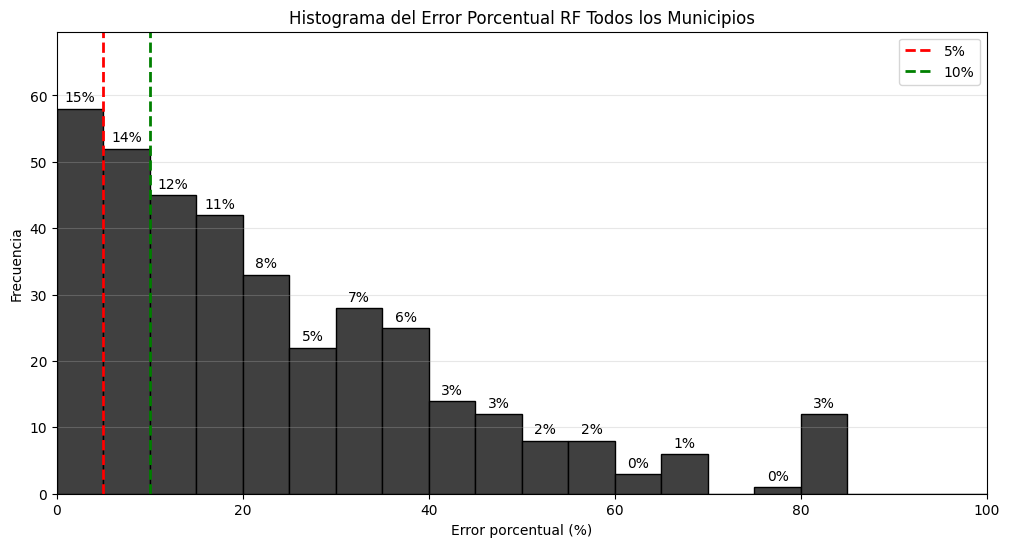

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_all_municipios_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipios_ch_simple`

In [ ]:
results_model_rf_municipio_ch_simple = evaluation_table(
    rf_municipio_ch_simple,
    X_test_prep_ch,   # ← NO convertir a DataFrame
    y_test_ch.values, # ← log target correcto
    df.loc[test_indices_ch],  # ← datos originales
    extra_cols=["url"]
)

results_model_rf_municipio_ch_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"300,000.00","472,964.17","172,964.17",57.65,https://www.casasymas.com.uy/propiedad/145602-...
1,"800,000.00","351,851.70","448,148.30",56.02,https://www.casasymas.com.uy/propiedad/189037-...
2,"110,000.00","165,634.71","55,634.71",50.58,https://www.casasymas.com.uy/propiedad/179372-...
3,"220,000.00","328,613.25","108,613.25",49.37,https://www.casasymas.com.uy/propiedad/138003-...
4,"439,000.00","630,376.58","191,376.58",43.59,https://www.casasymas.com.uy/propiedad/74195-c...
5,"140,000.00","192,770.50","52,770.50",37.69,https://www.casasymas.com.uy/propiedad/223429-...
6,"530,000.00","342,172.86","187,827.14",35.44,https://www.casasymas.com.uy/propiedad/108760-...
7,"330,000.00","446,645.52","116,645.52",35.35,https://www.casasymas.com.uy/propiedad/187067-...
8,"147,000.00","197,927.83","50,927.83",34.64,https://www.casasymas.com.uy/propiedad/192090-...
9,"515,000.00","346,230.68","168,769.32",32.77,https://www.casasymas.com.uy/propiedad/191507-...


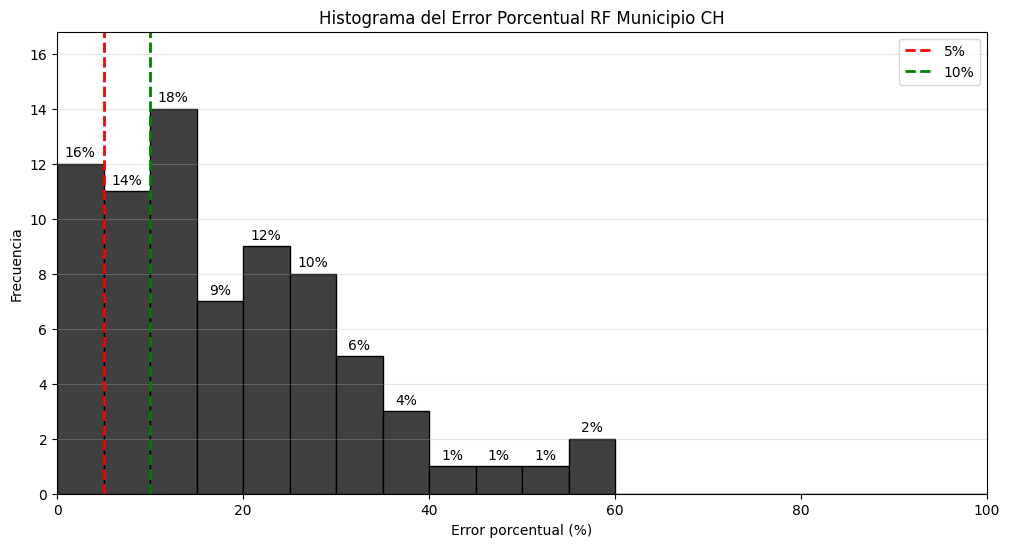

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipio_e_simple`

In [ ]:
results_model_rf_municipio_e_simple = evaluation_table(
    rf_municipio_e_simple,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_rf_municipio_e_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"75,000.00","215,944.82","140,944.82",187.93,https://www.casasymas.com.uy/propiedad/190700-...
1,"260,000.00","565,010.45","305,010.45",117.31,https://www.casasymas.com.uy/propiedad/188428-...
2,"360,000.00","632,093.51","272,093.51",75.58,https://www.casasymas.com.uy/propiedad/191076-...
3,"148,000.00","252,131.29","104,131.29",70.36,https://www.casasymas.com.uy/propiedad/216574-...
4,"165,000.00","263,360.24","98,360.24",59.61,https://www.casasymas.com.uy/propiedad/187249-...
5,"625,000.00","992,194.29","367,194.29",58.75,https://www.casasymas.com.uy/propiedad/1326-ca...
6,"2,000,000.00","931,184.90","1,068,815.10",53.44,https://www.casasymas.com.uy/propiedad/1322-ca...
7,"203,400.00","311,487.58","108,087.58",53.14,https://www.casasymas.com.uy/propiedad/90237-c...
8,"1,200,000.00","615,658.97","584,341.03",48.70,https://www.casasymas.com.uy/propiedad/200076-...
9,"1,150,000.00","595,187.06","554,812.94",48.24,https://www.casasymas.com.uy/propiedad/201123-...


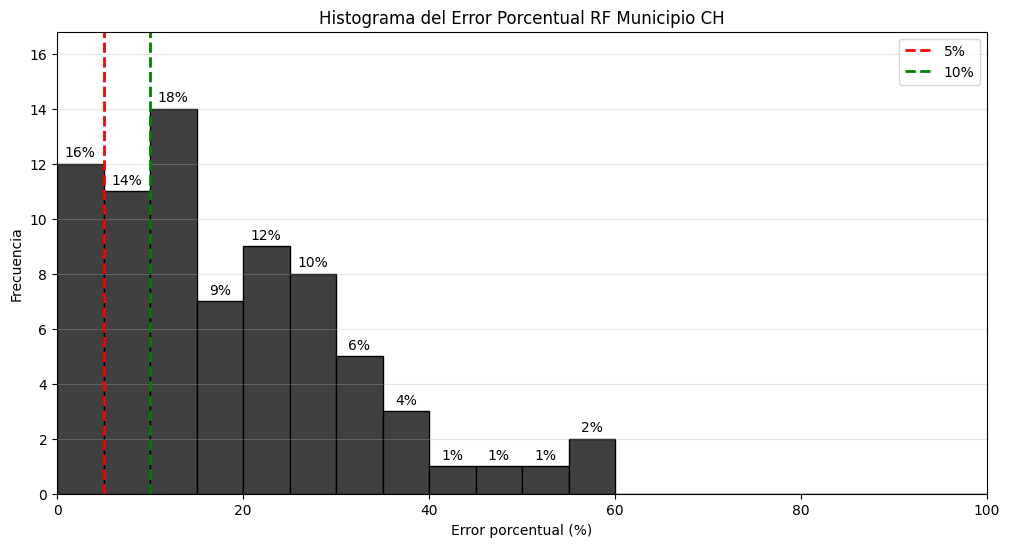

In [ ]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

## Model Performance 2: modelos agrupados por municipio